# Counting collisions in random circuit sampling for benchmarking quantum computers

This notebook can be used to reproduce all the results presented in the paper _Counting collisions in random circuit sampling for benchmarking quantum computers_, [arXiv:2312.04222](https://arxiv.org/abs/2312.04222) (2023).





### Table of contents
1. [Preliminary facts about random quantum states](#preliminary)
2. [Analytical formula derived in the paper](#formula)
3. [Empirical number of collisions](#collisions)
4. [Collision anomaly](#anomaly)
5. [Cross-collisions between two ideal quantum computers](#cross-collisions)
6. [Collisions for a noisy quantum computer](#noisy-collisions)
7. [Cross-collisions between two noisy quantum computers](#noisy-cross-collisions)
8. [Sampling cost and time cost of collisions-based experiments](#sampling-cost)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc

# In this notebook we use Qiskit only for generating random state vectors.
# Any other library or even a custom function could be used intstead.
from qiskit.quantum_info import random_statevector

In [2]:
n_qubits = 16
D = 2 ** n_qubits
trials = 1  # Number of experiment repetitions

# Fidelity parameter used in the paper. It must be between 0 (max noise) and 1 (no noise).
alpha = 1.0  

# Plotting options
SAVE_FIGS = False
FONT_SIZE = 15
linewidth = 2.3
TEX_FONT = True
if TEX_FONT:
    rc('text', usetex=True)
alpha_style = 0.8
plt.rcParams.update({"font.family": "serif", "font.size": FONT_SIZE})

<a name="preliminary"></a>
## Preliminary facts about random quantum states

In [3]:
def get_quantum_probs(D, alpha):
    """Returns the measurement probabilities of a Haar-random state of dimension D and fidelity alpha."""
    random_state = random_statevector(D)
    all_probs = random_state.probabilities()
    uniform = np.ones(D)/D
    return alpha * all_probs + (1 - alpha) * uniform

The probability of measuring a Haar-random state in the computational basis is close but not equal to the uniform distribution.

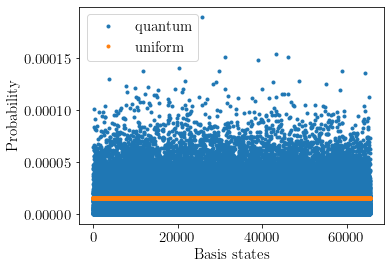

In [4]:
# Classical uniform distribution
uniform_probs = np.ones(D)/D

# Quantum distribution
all_probs = get_quantum_probs(D, alpha)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(all_probs, ".", label="quantum")
plt.plot(uniform_probs, ".", label="uniform")
plt.ylabel("Probability")
plt.xlabel("Basis states")
plt.legend()
plt.show()

The probaiblisties of a *single* typical random state are Porter-Thomas distributed, as shown in the next code cell.

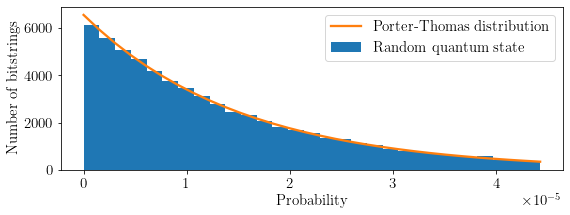

In [5]:
bin_size = 0.1 / D
p_vals = np.arange(0, 3 / D, bin_size)
# Number of bitstrings with p in [p, p+binsize] is D P(p) dp, where P(p)=De^(-DP)
expected_counts_in_bin = bin_size * D**2 * np.exp(-D*p_vals)

plt.figure(figsize=(9, 3))
plt.hist(all_probs, label="Random quantum state", bins=p_vals)
plt.plot(p_vals, expected_counts_in_bin, label="Porter-Thomas distribution", linewidth=linewidth)
plt.plot()
plt.ylabel("Number of bitstrings")
plt.xlabel("Probability")
plt.legend()
plt.show()

Averaging over many random states, the histogram would converge to the theoretical line. **However, even for a single instance of a random state, the Porter-Thomas distribution is typically a very good approximation.**

The fact that the probabilities associated to pure random quantum states are not uniformly distributed implies  that we can expect __a larger number of collisions__ compared to the trivial case of sampling random numbers from the uniform distribution.

In the rest of this notebook we verify this intuition and provide quantitative benchmarks for the quality of a quantum computer based on the number of observed collisions in a random sampling experiment.

<a name="formula"></a>
## Analytical formula derived in the paper

The expected number of collisions can be theoretically computed for a quantum state and for the uniform distribution. See arXiv paper for the derivation.

In [6]:
def collisions_q(dimension, shots, alpha=1):
    """Expected number of collisions for a random quantum state prepared with fidelity alpha."""
    return shots - dimension + (dimension ** 2) * np.exp(-(1 - alpha) * shots / dimension) / (alpha * shots + D)

def collisions_u(dimension, shots, approx_to_exp=True):
    """Expected number of collisions when sampling from the uniform distribution 
    (or from a maximally mixed state).
    """
    if approx_to_exp:
        return shots - dimension * (1 - np.exp(-shots/dimension))
    return shots - dimension + (dimension * (1 - 1 / dimension)**shots)

def delta_theory(dimension, shots, alpha=1):
    """Expected normalized difference in the number of collisions."""
    difference = collisions_q(dimension, shots, alpha) - collisions_u(dimension, shots, approx_to_exp=True)
    normalization = collisions_q(dimension, shots, 1) - collisions_u(dimension, shots, approx_to_exp=True)
    return difference / normalization


The expected number of cross-collisions can be theoretically computed for two devices (quantum or uniform). See arXiv paper for the derivation.

In [7]:
def x_collisions_qq(dimension, shots_a, shots_b, alpha):
    """Expected number of cross-collisions for two random quantum states."""
    return collisions_q(dimension, shots_a + shots_b, alpha) - collisions_q(dimension, shots_a, alpha) - collisions_q(dimension, shots_b, alpha)

def x_collisions_uu(dimension, shots_a, shots_b):
    """Expected number of cross-collisions when sampling from two uniform distributions 
    (or from two maximally mixed states).
    """
    return collisions_u(dimension, shots_a + shots_b) - collisions_u(dimension, shots_a) - collisions_u(dimension, shots_b)

def x_collisions_qu(dimension, shots_a, shots_b):
    """Expected number of cross-collisions when sampling from a quantum distribution
    and a uniform distribution.
    """
    return shots_a + shots_b - dimension + (dimension ** 2) * np.exp(- shots_b / dimension) / (shots_a + D) - collisions_q(dimension, shots_a) - collisions_u(dimension, shots_b)

def x_delta_theory(dimension, shots_a, shots_b, alpha):
    """Expected difference in the number of collisions."""
    difference = x_collisions_qq(dimension, shots_a , shots_b, alpha) - x_collisions_uu(dimension, shots_a, shots_b)
    normalization = x_collisions_qq(dimension, shots_a , shots_b, 1) - x_collisions_uu(dimension, shots_a, shots_b)
    return difference / normalization


 <a name="collisions"></a>
 ## Empirical number of collisions

Count the number of collisions when measuring a random quantum state.

In [8]:
shots_list = np.linspace(10, 64 * np.sqrt(D), 60, dtype=int)

all_number_of_collisions = []
for trial in range(trials):
    all_probs = get_quantum_probs(D, alpha)
    number_of_collisions = []
    for shots in shots_list:
        results = np.random.choice(range(D), size=shots, p=all_probs)
        unique_results = np.unique(results)
        number_of_collisions.append(shots - len(unique_results))
    all_number_of_collisions.append(number_of_collisions)

Count the number of collisions when sampling from the uniform distribution (classical random number generator).

In [9]:
all_number_of_collisions_uniform = []
for trial in range(trials):
    number_of_collisions = []
    for shots in shots_list:
        results = np.random.choice(range(D), size=shots)
        unique_results = np.unique(results)
        number_of_collisions.append(shots - len(unique_results))
    all_number_of_collisions_uniform.append(number_of_collisions)

In [10]:
# Average over trials
mean_number_of_collisions = np.mean(all_number_of_collisions, axis=0)
mean_number_of_collisions_uniform = np.mean(all_number_of_collisions_uniform, axis=0)

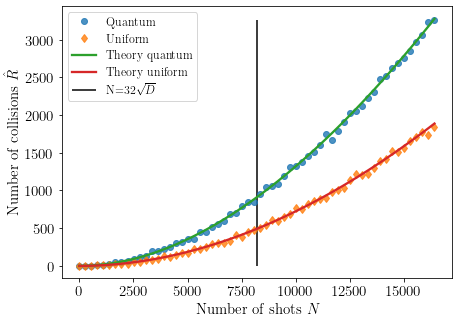

In the above plot, n_qubits=16, D=65536, N=32*sqrt(D)=8192.0


In [11]:
# Visualize
plt.figure(figsize=(7, 5))
plt.plot(shots_list, mean_number_of_collisions, "o", label="Quantum", alpha=alpha_style)
plt.plot(shots_list, mean_number_of_collisions_uniform, "d", label="Uniform", alpha=alpha_style)
plt.plot(shots_list, collisions_q(D, shots_list), "-", label="Theory quantum", linewidth=linewidth)
plt.plot(shots_list, collisions_u(D, shots_list, True), "-", label="Theory uniform",  linewidth=linewidth)
plt.vlines(32 * np.sqrt(D), 0, np.max(mean_number_of_collisions), label="N=32$\\sqrt{D}$", color="black")

plt.xlabel("Number of shots $N$")
plt.ylabel("Number of collisions $\hat R$")
plt.legend(fontsize=FONT_SIZE *0.8)

if SAVE_FIGS:
    plt.savefig("collisions.pdf" , bbox_inches='tight', pad_inches=0.1)
    
plt.show()
print(f"In the above plot, n_qubits={n_qubits}, D={D}, N=32*sqrt(D)={32 * np.sqrt(D)}")

### Educated guess for the number of shots

As discussed in the paper, a good choice of the number of shots is $$N=32 \sqrt{D}=2^{n/2 + 5},$$
which should be enough to observe $\gtrsim 500$ collisions and, therefore, enough to distinguish the quantum distribution from the uniform distribution with a good statistical confidence.

Let's verify this assumption in the next code cell.

In [12]:
q_colls = collisions_q(D, 32*np.sqrt(D))
u_colls = collisions_u(D, 32*np.sqrt(D))
print(f"Expected number of collisions at N=32*sqrt(D)={32*np.sqrt(D)} shots:")
print("Quantum =", q_colls)
print("Uniform =", u_colls)
print("Ratio quantum/uniform =", q_colls/u_colls)

Expected number of collisions at N=32*sqrt(D)=8192.0 shots:
Quantum = 910.222222222219
Uniform = 491.31700778404775
Ratio quantum/uniform = 1.8526169617606558


  <a name="anomaly"></a>
 ## Collision anomaly
 The collision anomaly $\hat\Delta$ is defined as:
 
 $$ \hat \Delta := \frac{\hat R - \mathbb E_u(\hat R)}{\mathbb E_q(\hat R)-\mathbb E_u(\hat R)}$$
 and quantifies the excess of collisions when sampling from a quantum state with respect to the base level given by the uniform distribution.

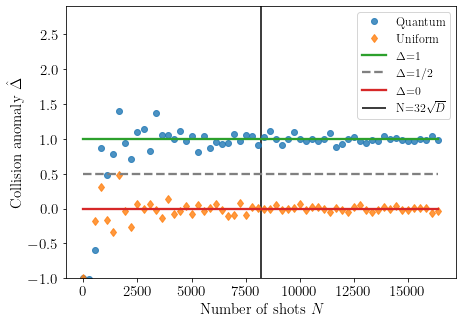

In the above plot, n_qubits=16, D=65536, N=32*sqrt(D)=8192.0


In [13]:
mean_anomaly = (mean_number_of_collisions - collisions_u(D, shots_list)) / (collisions_q(D, shots_list, 1) - collisions_u(D, shots_list))
mean_anomaly_uniform = (mean_number_of_collisions_uniform - collisions_u(D, shots_list)) / (collisions_q(D, shots_list, 1) - collisions_u(D, shots_list))

plt.figure(figsize=(7, 5))
plt.plot(shots_list, mean_anomaly, "o", label="Quantum", alpha=alpha_style)
plt.plot(shots_list, mean_anomaly_uniform, "d", label="Uniform", alpha=alpha_style)
plt.plot(shots_list, delta_theory(D, shots_list), "-", label="$\Delta$=1",  linewidth=linewidth)
plt.plot(shots_list, 0.5 * np.ones_like(shots_list), "--", label="$\Delta$=1/2",  linewidth=linewidth, color="gray")
plt.plot(shots_list, delta_theory(D, shots_list, 0), "-", label="$\Delta$=0",  linewidth=linewidth)

plt.xlabel("Number of shots $N$")
plt.ylabel("Collision anomaly $\hat \Delta$")

max_y= 2.9
min_y= -1.0
plt.vlines(32 * np.sqrt(D), min_y, max_y, label="N=32$\\sqrt{D}$", color="black")
plt.ylim(min_y, max_y)
plt.legend(fontsize=FONT_SIZE * 0.8)#loc=(1.04, 0.4))

if SAVE_FIGS:
    plt.savefig("normalized_delta.pdf", bbox_inches="tight")
plt.show()
print(f"In the above plot, n_qubits={n_qubits}, D={D}, N=32*sqrt(D)={32 * np.sqrt(D)}")

 <a name="cross-collisions"></a>
## Cross-collisions between two ideal quantum computers
We now consider the number of cross-collisions observed by two agents Alice and Bob, who take samples from two independent devices. The devices of Alice and Bob can be different. We consider the following combinations:
1. quantum-quantum (same random state)
2. uniform-uniform
3. quantum-uniform
4. quantum-quantum (but different states)

The number of cross-collisions quantifies how much two devices, $A$ and $B$, tend to produce equal measurement outcomes. It can be defined as follows:

$$\hat R_X := \hat R_{AB} - \hat R_A - \hat R_B = \hat W_A + \hat W_B - \hat W_{AB},$$

where $\hat R_{AB}$ is the number of collisions observed when merging the results of A and B into a unique dataset, while $\hat R_A$ and $\hat R_B$ are the number of collisions observed on each device. The same quantity can be easily computed in terms of the number of unique bitstrings $\hat W_{AB}$, $\hat W_A$, $\hat W_B$, as shown in the next code cell.


In [14]:
all_number_of_collisions_qq = []
all_number_of_collisions_uu = []
all_number_of_collisions_qu = []
all_number_of_collisions_qqp = []
for trial in range(trials):
    pure_probs = get_quantum_probs(D, alpha=1)
    uniform = get_quantum_probs(D, alpha=0)
    number_of_collisions_x_cases = []
    for case in ["qq", "uu", "qu", "qqp"]:
        if case == "qq":
            all_probs_a = pure_probs
            all_probs_b = pure_probs
        elif case == "uu":
            all_probs_a = uniform
            all_probs_b = uniform
        elif case == "qu":
            all_probs_a = pure_probs
            all_probs_b = uniform
        elif case == "qqp":
            all_probs_a = pure_probs
            all_probs_b = get_quantum_probs(D, alpha=1)
        number_of_collisions_x = []
        for shots in shots_list:
            results_a = np.random.choice(range(D), size=shots, p=all_probs_a)
            results_b = np.random.choice(range(D), size=shots, p=all_probs_b)
            results_ab = np.concatenate((results_a, results_b))
            unique_results_ab = np.unique(results_ab)
            unique_results_a = np.unique(results_a)
            unique_results_b = np.unique(results_b)
            number_of_collisions_x.append(
                len(unique_results_a) + len(unique_results_b) - len(unique_results_ab)
            )
        number_of_collisions_x_cases.append(number_of_collisions_x)
    all_number_of_collisions_qq.append(number_of_collisions_x_cases[0])
    all_number_of_collisions_uu.append(number_of_collisions_x_cases[1])
    all_number_of_collisions_qu.append(number_of_collisions_x_cases[2])
    all_number_of_collisions_qqp.append(number_of_collisions_x_cases[3])

# Average over trials
mean_number_of_collisions_qq = np.mean(all_number_of_collisions_qq, axis=0)
mean_number_of_collisions_uu = np.mean(all_number_of_collisions_uu, axis=0)
mean_number_of_collisions_qu = np.mean(all_number_of_collisions_qu, axis=0)
mean_number_of_collisions_qqp = np.mean(all_number_of_collisions_qqp, axis=0)

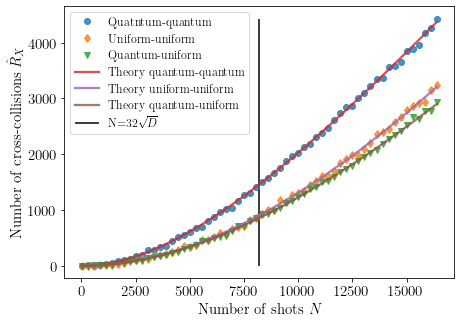

In the above plot, n_qubits=16, D=65536


In [15]:
plt.figure(figsize=(7, 5))
plt.plot(shots_list, mean_number_of_collisions_qq, "o", label="Quatntum-quantum", alpha=alpha_style)
plt.plot(shots_list, mean_number_of_collisions_uu, "d", label="Uniform-uniform", alpha=alpha_style)
plt.plot(shots_list, mean_number_of_collisions_qu, "v", label="Quantum-uniform", alpha=alpha_style)
#plt.plot(shots_list, mean_number_of_collisions_qqp, "o", label="Quantum-uniform", alpha=alpha_style)


plt.plot(shots_list, x_collisions_qq(D, shots_list, shots_list, alpha=1), "-", label="Theory quantum-quantum", linewidth=linewidth, alpha=alpha_style)
plt.plot(shots_list, x_collisions_uu(D, shots_list, shots_list), "-", label="Theory uniform-uniform", linewidth=linewidth, alpha=alpha_style)
plt.plot(shots_list, x_collisions_qu(D, shots_list, shots_list), "-", label="Theory quantum-uniform", linewidth=linewidth, alpha=alpha_style)

plt.vlines(32 * np.sqrt(D), 0, max(mean_number_of_collisions_qq), label="N=32$\\sqrt{D}$", color="black")


plt.xlabel("Number of shots $N$")
plt.ylabel("Number of cross-collisions $\hat R_X$")
plt.legend(fontsize=FONT_SIZE *0.8)

if SAVE_FIGS:
    plt.savefig(f"collisions_x.pdf" , bbox_inches='tight', pad_inches=0.1)
plt.show()
print(f"In the above plot, n_qubits={n_qubits}, D={D}")

The cross-collision anomaly is defined as:
 
 $$ \hat \Delta_X := \frac{\hat R_X - \mathbb E_{uu}(\hat R_X)}{\mathbb E_{qq}(\hat R_X)-\mathbb E_{uu}(\hat R_X)}$$
 and quantifies the excess of cross-collisions when sampling from two equal quantum states with respect to  the base level of sampling from the uniform distribution.

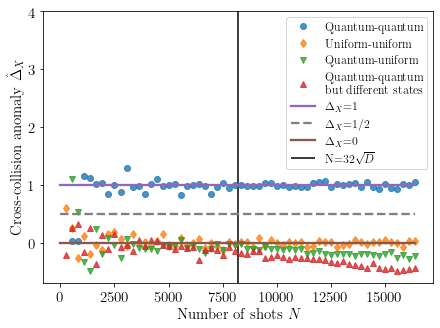

In the above plot, n_qubits=16, D=65536, N=32*sqrt(D)=8192.0


In [16]:
######### X-DELTA ###################à
plt.figure(figsize=(7, 5))

mean_anomaly_qq = (mean_number_of_collisions_qq - x_collisions_uu(D, shots_list, shots_list)) / (x_collisions_qq(D, shots_list, shots_list, 1) - x_collisions_uu(D, shots_list, shots_list))
mean_anomaly_uu = (mean_number_of_collisions_uu - x_collisions_uu(D, shots_list, shots_list)) / (x_collisions_qq(D, shots_list, shots_list, 1) - x_collisions_uu(D, shots_list, shots_list))
mean_anomaly_qu = (mean_number_of_collisions_qu - x_collisions_uu(D, shots_list, shots_list)) / (x_collisions_qq(D, shots_list, shots_list, 1) - x_collisions_uu(D, shots_list, shots_list))
mean_anomaly_qqp = (mean_number_of_collisions_qqp - x_collisions_uu(D, shots_list, shots_list)) / (x_collisions_qq(D, shots_list, shots_list, 1) - x_collisions_uu(D, shots_list, shots_list))

        
plt.plot(shots_list, mean_anomaly_qq, "o", label=f"Quantum-quantum", alpha=alpha_style)
plt.plot(shots_list, mean_anomaly_uu, "d", label=f"Uniform-uniform", alpha=alpha_style)
plt.plot(shots_list, mean_anomaly_qu, "v", label=f"Quantum-uniform", alpha=alpha_style)
plt.plot(shots_list, mean_anomaly_qqp, "^", label=f"Quantum-quantum\nbut different states", alpha=alpha_style)


plt.plot(shots_list, x_delta_theory(D, shots_list, shots_list, 1), "-", label="$\Delta_X$=1",  linewidth=linewidth)
plt.plot(shots_list, 0.5 * np.ones_like(shots_list), "--", label="$\Delta_X$=1/2",  linewidth=linewidth, color="gray")
plt.plot(shots_list, x_delta_theory(D, shots_list, shots_list, 0), "-", label="$\Delta_X$=0",  linewidth=linewidth)

plt.xlabel("Number of shots $N$")
plt.ylabel("Cross-collision anomaly $\hat \Delta_X$")

max_y= 4
min_y= -0.7

plt.vlines(32 * np.sqrt(D), min_y, max_y, label="N=32$\\sqrt{D}$", color="black")

plt.ylim(min_y, max_y)
plt.legend(fontsize=FONT_SIZE * 0.8)#loc=(1.04, 0.4))

if SAVE_FIGS:
    plt.savefig(f"normalized_delta_x.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()
print(f"In the above plot, n_qubits={n_qubits}, D={D}, N=32*sqrt(D)={32 * np.sqrt(D)}")

  <a name="noisy-collisions"></a>
 ## Collisions for a noisy quantum computer

We now consider a noisy quantum computer which is able prepare the following noisy quantum state:

$$ \rho = \alpha | \psi \rangle \langle \psi | + (1- \alpha) \mathbb{1}/D,$$

where $| \psi\rangle$ is a random pure state (e.g. associated to some given random circuit), while $\mathbb{1}/D$ is the maximally mixed state.

For different values of $\alpha$, we repeat the previous analysis. I.e., we compute the number of observed collisions and the collision anomaly. 

In [17]:
alphas = [1, 0.0, 0.5, 0.8]

mean_number_of_collisions_alphas = []
for _alpha in alphas:
    all_number_of_collisions_noisy = []
    for trial in range(trials):
        all_probs_noisy = get_quantum_probs(D, _alpha)
        number_of_collisions_noisy = []
        for shots in shots_list:
            results_noisy = np.random.choice(range(D), size=shots, p=all_probs_noisy)
            unique_results_noisy = np.unique(results_noisy)
            number_of_collisions_noisy.append(shots - len(unique_results_noisy))
        all_number_of_collisions_noisy.append(number_of_collisions_noisy)

    # Average over trials
    mean_number_of_collisions_noisy = np.mean(all_number_of_collisions_noisy, axis=0)
    mean_number_of_collisions_alphas.append(mean_number_of_collisions_noisy)

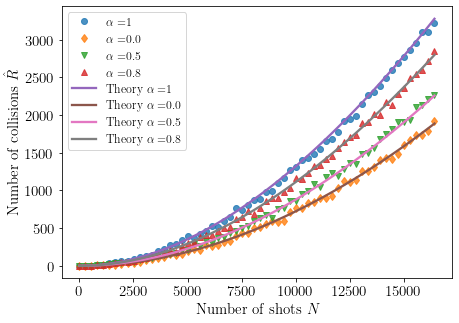

In the above plot, n_qubits=16, D=65536


In [18]:
plt.figure(figsize=(7, 5))
markers = ["^", "v", "d", "o"]

for _alpha, mean_coll_alpha in zip(alphas, mean_number_of_collisions_alphas):
    plt.plot(shots_list, mean_coll_alpha, markers.pop(), label=f"$\\alpha=${_alpha}", alpha=alpha_style)

for _alpha in alphas:
    plt.plot(shots_list, collisions_q(D, shots_list, _alpha), "-", label=f"Theory $\\alpha=${_alpha}", linewidth=linewidth)


#max_y = np.max(mean_number_of_collisions - collisions_q(D, shots_list, 0))
#for _alpha in alphas:  
#    plt.vlines(
#        32 * np.sqrt(D) / _alpha ** 2, 0, max_y,
#        label="N=32$\\sqrt{D}"+f"/{_alpha}$",
#        color="black",
#    )

plt.xlabel("Number of shots $N$")
plt.ylabel("Number of collisions $\hat R$")
plt.legend(fontsize=FONT_SIZE *0.8)

if SAVE_FIGS:
    plt.savefig("collisions_alphas.pdf" ,bbox_inches='tight', pad_inches=0.1)
    
plt.show()
print(f"In the above plot, n_qubits={n_qubits}, D={D}")

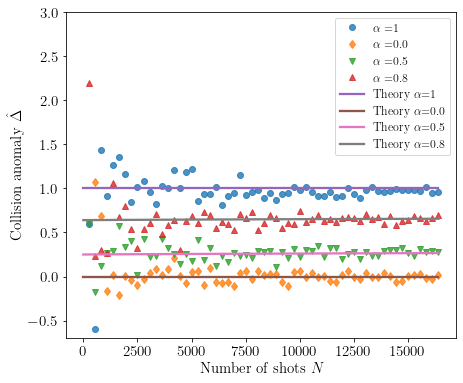

In the above plot, n_qubits=16, D=65536, N=32*sqrt(D)=8192.0


In [19]:
plt.figure(figsize=(7, 6))

markers = ["^", "v", "d", "o"]

for _alpha, mean_coll_alpha in zip(alphas, mean_number_of_collisions_alphas):
    mean_anomaly_alpha = (mean_coll_alpha - collisions_u(D, shots_list)) / (collisions_q(D, shots_list, 1) - collisions_u(D, shots_list))
    plt.plot(shots_list, mean_anomaly_alpha, markers.pop(), label=f"$\\alpha=${_alpha}", alpha=alpha_style)

for _alpha in alphas:
    plt.plot(shots_list, delta_theory(D, shots_list, _alpha), "-", label=f"Theory $\\alpha$={_alpha}",  linewidth=linewidth)

# plt.hlines(1/2, 0, max(shots_list), label="1/2", color="gray", linestyle="--",  linewidth=linewidth)
plt.xlabel("Number of shots $N$")
plt.ylabel("Collision anomaly $\hat \Delta$")

max_y= 3
min_y= -0.7

plt.ylim(min_y, max_y)
plt.legend(fontsize=FONT_SIZE * 0.8) #loc=(1.04, 0.4))

if SAVE_FIGS:
    plt.savefig("normalized_delta_alphas.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()
print(f"In the above plot, n_qubits={n_qubits}, D={D}, N=32*sqrt(D)={32 * np.sqrt(D)}")

 <a name="noisy-cross-collisions"></a>
## Cross-collisions between two noisy quantum computers

Also for the number of cross-collisions, we repeat the analysis assuming noisy quantum states. 

We consider three relevant cases: 
    1. Bob samples from a noisy random state equal to Alice's noisy random state
    2. Bob samples from the uniform distribution (infinitely mixed state)
    3. Bob samples from a pure random state, but different from Alice's random state.

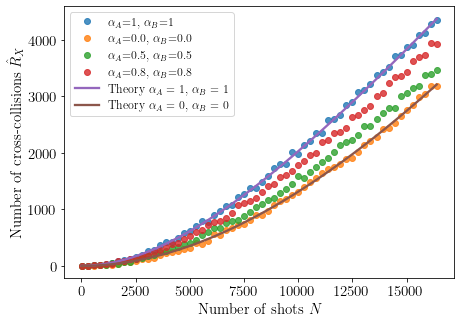

In the above plot, n_qubits=16, D=65536


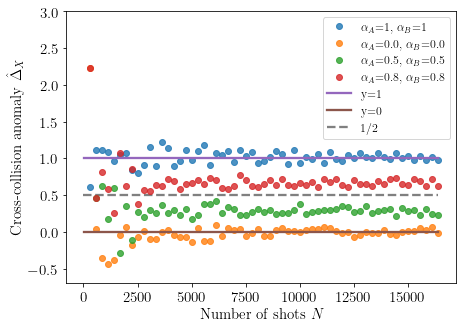

In the above plot, n_qubits=16, D=65536, N=32*sqrt(D)=8192.0


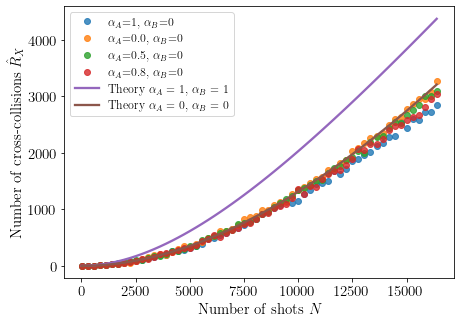

In the above plot, n_qubits=16, D=65536


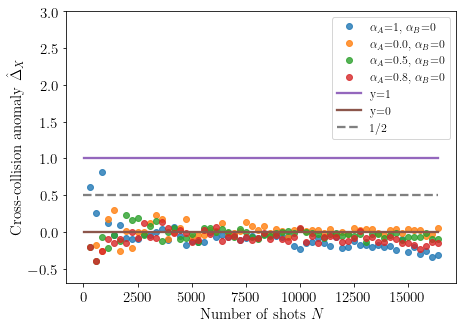

In the above plot, n_qubits=16, D=65536, N=32*sqrt(D)=8192.0


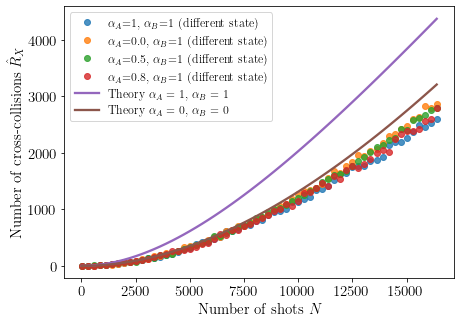

In the above plot, n_qubits=16, D=65536


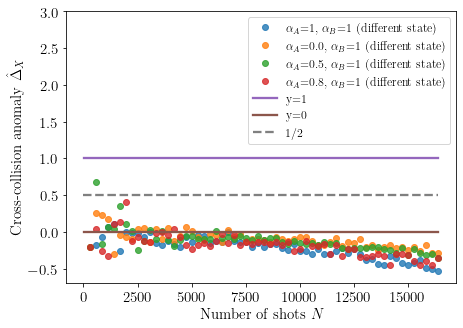

In the above plot, n_qubits=16, D=65536, N=32*sqrt(D)=8192.0


In [20]:
markers = ["^", "v", "d", "o"]


x_alphas = alphas
for bob in ["same", "uniform", "different"]:
    mean_number_of_collisions_alphas_x = []
    for _alpha_a in x_alphas:
        all_number_of_collisions_noisy_x = []
        for trial in range(trials):
            pure_probs = get_quantum_probs(D, alpha=1)
            uniform = get_quantum_probs(D, alpha=0)
            all_probs_noisy_a = _alpha_a * pure_probs + (1 - _alpha_a) * uniform
            if bob == "same":
                all_probs_noisy_b = all_probs_noisy_a
            elif bob == "uniform":
                all_probs_noisy_b = uniform
            elif bob == "different":
                all_probs_noisy_b = get_quantum_probs(D, alpha=1)
            number_of_collisions_noisy_x = []
            for shots in shots_list:
                results_noisy_a = np.random.choice(range(D), size=shots, p=all_probs_noisy_a)
                results_noisy_b = np.random.choice(range(D), size=shots, p=all_probs_noisy_b)
                results_noisy_ab = np.concatenate((results_noisy_a, results_noisy_b))
                unique_results_noisy_ab = np.unique(results_noisy_ab)
                unique_results_noisy_a = np.unique(results_noisy_a)
                unique_results_noisy_b = np.unique(results_noisy_b)
                number_of_collisions_noisy_x.append(
                    len(unique_results_noisy_a) + len(unique_results_noisy_b) - len(unique_results_noisy_ab)
                )
            all_number_of_collisions_noisy_x.append(number_of_collisions_noisy_x)

        # Average over trials
        mean_number_of_collisions_noisy_x = np.mean(all_number_of_collisions_noisy_x, axis=0)
        mean_number_of_collisions_alphas_x.append(mean_number_of_collisions_noisy_x)

    plt.figure(figsize=(7, 5))
    for _alpha_a, mean_coll_alpha in zip(x_alphas, mean_number_of_collisions_alphas_x):
        comment = ""
        if bob == "same":
            _alpha_b = _alpha_a
        elif bob == "uniform":
            _alpha_b = 0
        elif bob == "different":
            _alpha_b = 1
            comment = " (different state)"
        plt.plot(shots_list, mean_coll_alpha, "o", label=f"$\\alpha_A$={_alpha_a}, $\\alpha_B$={_alpha_b}" + comment, alpha=alpha_style)

    #for _alpha in alphas:
    #    plt.plot(shots_list, x_collisions_q(D, shots_list, shots_list, _alpha), "-", label=f"Theory $\\alpha=${_alpha}", linewidth=linewidth)
    plt.plot(shots_list, x_collisions_qq(D, shots_list, shots_list, 1), "-", label=f"Theory $\\alpha_A=$ {1}, $\\alpha_B=1$", linewidth=linewidth)
    plt.plot(shots_list, x_collisions_uu(D, shots_list, shots_list), "-", label=f"Theory $\\alpha_A=$ {0}, $\\alpha_B=0$", linewidth=linewidth)


    plt.xlabel("Number of shots $N$")
    plt.ylabel("Number of cross-collisions $\hat R_X$")
    plt.legend(fontsize=FONT_SIZE *0.8)

    #if SAVE_FIGS:
    #    plt.savefig(f"collisions_alphas_x_{bob}.pdf" , bbox_inches='tight', pad_inches=0.1)

    plt.show()
    print(f"In the above plot, n_qubits={n_qubits}, D={D}")


    ######### X-DELTA ###################à
    plt.figure(figsize=(7, 5))

    for _alpha_a, mean_coll_alpha in zip(x_alphas, mean_number_of_collisions_alphas_x):
        if bob == "same":
            _alpha_b = _alpha_a
        elif bob == "uniform":
            _alpha_b = 0
        elif bob == "different":
            _alpha_b = 1
        mean_anomaly_alpha_x = (mean_coll_alpha - x_collisions_uu(D, shots_list, shots_list)) / (x_collisions_qq(D, shots_list, shots_list, 1) - x_collisions_uu(D, shots_list, shots_list))
        
        comment = ""
        if bob == "different":
            comment = " (different state)"
        plt.plot(shots_list, mean_anomaly_alpha_x, "o", label=f"$\\alpha_A$={_alpha_a}, $\\alpha_B$={_alpha_b}" + comment, alpha=alpha_style)

    plt.plot(shots_list, x_delta_theory(D, shots_list, shots_list, 1), "-", label=f"y=1",  linewidth=linewidth)
    plt.plot(shots_list, x_delta_theory(D, shots_list, shots_list, 0), "-", label=f"y=0",  linewidth=linewidth)

    plt.hlines(1/2, 0, max(shots_list), label="1/2", color="gray", linestyle="--",  linewidth=linewidth)
    plt.xlabel("Number of shots $N$")
    plt.ylabel("Cross-collision anomaly $\hat \Delta_X$")

    max_y= 3
    min_y= -0.7

    plt.ylim(min_y, max_y)
    plt.legend(fontsize=FONT_SIZE * 0.8)#loc=(1.04, 0.4))

    #if SAVE_FIGS:
    #    plt.savefig(f"normalized_delta_alphas_x_{bob}.pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()
    print(f"In the above plot, n_qubits={n_qubits}, D={D}, N=32*sqrt(D)={32 * np.sqrt(D)}")

The effect of noise in cross-collisions experiments is similar to the effect of noise on single-device experiments. For this reason the above plots are not reported in the arXiv paper but are nontheless shown in this notebook for completeness.

 <a name="sampling-cost"></a>
## Sampling cost and time cost of collision-based experiments

In this section we estimate how many shots and how much time we need to run an experiment in which the number of collisions is enough to distinguish a noisy quantum state from a random number generator sampling from the uniform distribution. We assume a measurement rate of 1MHz.

As shown above, for an $n$-qubit ideal experiment, $N_{\rm min}=32 \sqrt{D}=2^{n/2 + 4}$ shots are appropriate to detect a collision excess with respect to the uniform distribution.

In the presence of noise ($\alpha \neq 1$), the formula must be normalized accordingly. As discussed in the arXiv paper, the formula must be normalized by $\alpha$:

$$N_{\rm min}(\alpha)=\frac{32 \sqrt{D}}{\alpha}=\frac{2^{n/2 + 4}}{\alpha}$$

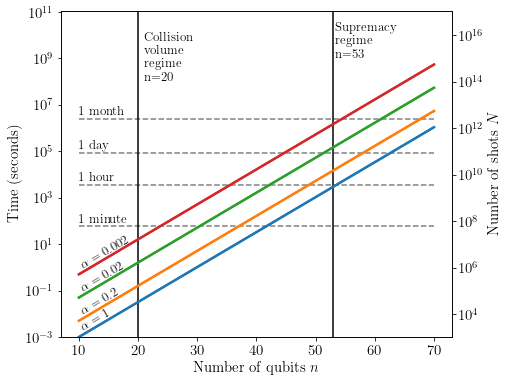

In [21]:
alphas_small = [1, 0.2, 0.02, 0.002]

n_min = 10
n_max = 70
n_qubit_list_volume_test = np.linspace(n_min, n_max, 100)
min_shots = 32 * 2**(n_qubit_list_volume_test/2)

shots_per_second = (1 / 1) * 10 ** 6
seconds_in_a_minute = 60
seconds_in_an_hour = seconds_in_a_minute * 60
seconds_in_a_day =  seconds_in_an_hour * 24
seconds_in_a_week = seconds_in_a_day * 7
seconds_in_a_month = seconds_in_a_day * 30

time = min_shots / shots_per_second

plt.figure(figsize=(7, 6))
for _alpha in alphas_small:
    plt.plot(n_qubit_list_volume_test, time / _alpha, "-", label=f"$\\alpha={_alpha}$", linewidth=linewidth)
    plt.text(
        n_qubit_list_volume_test[0],
        (1 + 0.88) * time[0] / _alpha,
        f"$\\alpha={_alpha}$",
        rotation=30,
        size=13,
    )


plt.xlabel("Number of qubits $n$")
plt.ylabel("Time (seconds)")


for y, name in zip(
    [seconds_in_a_minute, seconds_in_an_hour, seconds_in_a_day, seconds_in_a_month],
    ["minute", "hour", "day", "month"],
):
    plt.hlines(y, n_min, n_max, colors=["gray"], linestyle="--")
    plt.text(
        n_min,
        y * 1.5,
        f"1 {name}",
        rotation=0,
        size=13,
    )

y_min = 10 ** -3
y_max = 10**5 * max(time)   
    
plt.vlines(53, 0, y_max, colors=["black"])
plt.text(
        53.2,
        y_max * 0.01,
        f"Supremacy\nregime\nn=53",
        rotation=0,
        size=13,
    )
    
n_volume = 20
plt.vlines(n_volume, 0, y_max, colors=["black"])
plt.text(
        n_volume + 1,
        y_max * 0.001,
        f"Collision\nvolume\nregime\nn={n_volume}",
        rotation=0,
        size=13,
)



plt.ylim(y_min, y_max)
plt.yscale("log")
plt.twinx()
plt.ylim(y_min * shots_per_second, y_max * shots_per_second)
plt.yscale("log")
plt.ylabel("Number of shots $N$")

for _alpha in alphas_small:
    plt.plot(n_qubit_list_volume_test, min_shots / _alpha, "-", linewidth=linewidth, alpha=1)


#plt.legend()#loc=(0, 0.5))
if SAVE_FIGS:
    plt.savefig("time_and_shots_vs_qubits.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()


In the above plot, the first vertical line on the left represent a quantum computer with a limited number of high-quality qubits (collision volume regime). The second vertical line on the right represent a quantum computer with a large number of qubits that is hard to classically simulate (quantum supremacy regime).

From a direct observation of this plot we can deduce that:

- collision-based benchmarks such as the _collision anomaly_ or the _collision volume_ (introduced in the paper), are experimentally feasible with current technology.
- observing a non-zero _collision anomaly_ in the quantum supremacy regime is instead currently infeasible. It may become feasible if there will be significant improvements in the state preparation fidelity $\alpha$ and/or in the measurement repetition rate (e.g. with multi-core quantum processors).